In [14]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def roundfun(x_share):
    uplist = []
    x_round = np.round(x_share)
    j = 0
    for j in range(len(x_share)):
        if x_round[j] <= x_share[j]:
            uplist.append(0)
        else:
            uplist.append(1)
        j = j+1
    return x_round, uplist

In [3]:
# Example of rounded function

Z = [ 675.78975593 ,1018.34313283,   26.34372106 ,1468.29399009, 1041.61614148,
  659.93801356, 1097.86158098, 5425.37603531,   36.56702023, 1389.92028308,
  2560.43840833 , 426.9158793 ,  864.11348986 , 378.73721687, 1013.31610082,
  317.23253371 , 835.76164646 , 724.01749255, 1507.14437998,  904.34406961]
Z = np.array(Z)

a, b = roundfun(Z)
print(a)
print(b)

[ 676. 1018.   26. 1468. 1042.  660. 1098. 5425.   37. 1390. 2560.  427.
  864.  379. 1013.  317.  836.  724. 1507.  904.]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]


In [4]:
# Complete the following functions

# Strategy 1
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
  x_optimal = x_init
  cash_optimal = cash_init
  weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)
  return x_optimal, cash_optimal, weight_optimal

# Strategy 2
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):

    x_ratio = 1 / cur_prices # Amount of money to put in each stock, weighted equally
    p_current = np.dot(x_init, cur_prices)
    x_share = p_current/N * x_ratio
    x_optimal, roundlist = roundfun(x_share) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there'e enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):

        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal) # Number of units changed
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC

        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 # Buy 1 less stock of all stocks above 1
            # This would essentially round all share units down 1 so you would have enough money
            # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
    
    # Use extra cash since we undershot our number of stocks
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        # Cost adding 1 extra unit
        current_price = current_price + cur_prices[i]
        
        # Don't add the units that were rounded down or if not enough money
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        # Add only the units that were supposed to be rounded up
        else:
            extra_share.append(1) # Include stock

    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)

    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)

    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)

    return x_optimal, cash_optimal, weight_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    # Initialize the CPLEX Object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Define linear part of objective function and bounds on variables
    c  = [0.0] * N # Weights
    lb = [0.0] * N # No short selling boundary
    ub = [1.0] * N # Upper limit boundary
    
    # Define constraint matrix A
    A = []
    
    for k in range(N):
        A.append([[0],[1.0]]) # Upper limit boundary
    
    # Add objective function, bounds on variables and linear constraints to CPLEX model
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E") # Sum of weights add up to 1
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute minimum variance with CPLEX
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    # Optimize the problem
    cpx.solve()
    
    x_ratio = np.array(cpx.solution.get_values()) # Weight to put in each stock
    p_current = np.dot(x_init, cur_prices)
    v_current = p_current * x_ratio
    x_optimal, roundlist = roundfun(v_current / cur_prices) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there'e enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):
        
        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal)
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC
            
        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 #Buy 1 less stock of all stocks above 1
        # This would essentially round all share units down 1 so you would have enough money
        # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
        
    # Use extra cash since we undershot our number of stocks
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        # Cost adding 1 extra unit
        current_price = current_price + cur_prices[i]
        
        # Don't add the units that were rounded down or if not enough money
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        # Add only the units that were supposed to be rounded up
        else:
            extra_share.append(1) # Include stock
    
    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)
    
    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)

    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)  
    
    return x_optimal, cash_optimal, weight_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    # Initialize the CPLEX Object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Define linear part of objective function and bounds on variables
    c  = [0.0] * N
    lb = [0.0] * N
    ub = [cplex.infinity] * N
    
    # Define constraint matrix A
    A = []
    
    for k in range(N):
        A.append([[0],[mu[k] - 1/252 * r_rf]]) # Annual risk free rate given, convert to daily
    
    # Add objective function, bounds on variables and linear constraints to CPLEX model
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    cpx.variables.add(obj=c, lb = lb, ub=ub, columns=A, names=var_names)
    
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute minimum variance with CPLEX
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    # Optimize the problem
    cpx.solve()
    
    # get x_optimal
    y = np.array(cpx.solution.get_values())
    x_ratio = y / np.sum(y)
    p_current = np.dot(x_init, cur_prices)
    v_current = p_current * x_ratio
    x_optimal, roundlist = roundfun(v_current / cur_prices) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there'e enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):
        
        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal)
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC
            
        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 #Buy 1 less stock of all stocks above 1
        # This would essentially round all share units down 1 so you would have enough money
        # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
        
    # Need to use extra cash
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        current_price = current_price + cur_prices[i]
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        else:
            extra_share.append(1) # Include stock
    
    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)
    
    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)
    
    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)
    
    return x_optimal, cash_optimal, weight_optimal

In [5]:
# Input file
input_file_prices = 'C:/Users/alex_/Downloads/Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025


Initial portfolio value = $ 1000012.93



In [6]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
# N_strat = 4  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Added

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      # Calculate optimal weight as well

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # verify strategy is feasible
      if cash[strategy].any() < 0:
          print('Strategy "{0}" is not feasible.'.format(strategy_names[strategy]))

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990881.80, value end = $ 892363.31
  Strategy "Minimum Variance Portfolio", value begin = $ 992756.25, value end = $ 915852.04
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990063.24, value end = $ 922013.36

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 930689.62, value end = $ 862184.18
  Strategy "Minimum Variance Portfolio", value begin = $ 955715.61, value end = $ 850657.72
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 961925.43, value end = $ 1017080.07

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
  Strategy "Equally Weighted Portfolio", v

# Part 2 - Analyze your Results

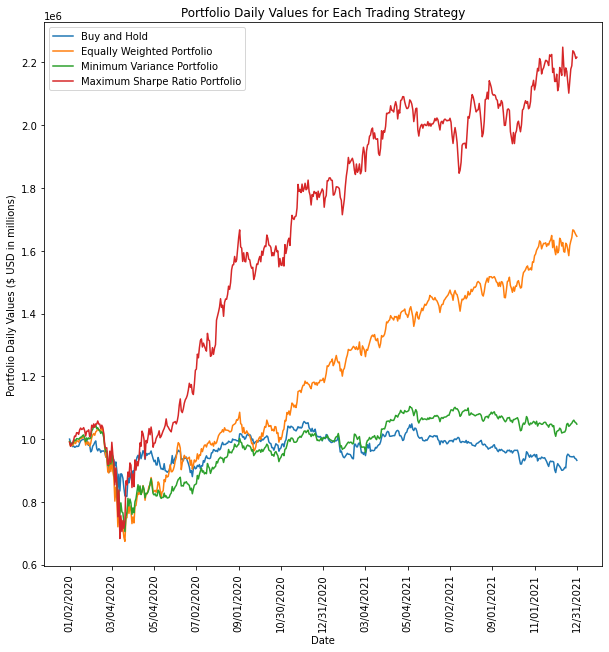

In [7]:
# Plot results
###################### Insert your code here ############################

# This chart illustrates the daily value of the portfolio for each 
# trading strategy over the years 2020 and 2021 using the daily prices. 

figure(figsize=(10, 10))

# Plotting the points
plt.plot(dates, portf_value[0], label = strategy_names[0])
plt.plot(dates, portf_value[1], label = strategy_names[1])
plt.plot(dates, portf_value[2], label = strategy_names[2])
plt.plot(dates, portf_value[3], label = strategy_names[3])

# X axis date ticks
plt.xticks(list(dates[k] for k in list(np.linspace(0,252*2,13,dtype=int))),rotation=90)

# Labelling
plt.xlabel('Date')
plt.ylabel('Portfolio Daily Values ($ USD in millions)')
plt.title('Portfolio Daily Values for Each Trading Strategy')
plt.legend()
plt.show()

## Plotting Minimum Variance Dynamic Portfolio Allocation

In [8]:
weight_2 = weight[2].tolist()
weight_2_df = pd.DataFrame(weight_2, columns = df.columns[1:]) # Remove the date

Text(0.5, 1.0, 'Dynamic Changes in Portfolio Allocations for Minimum Variance Strategy')

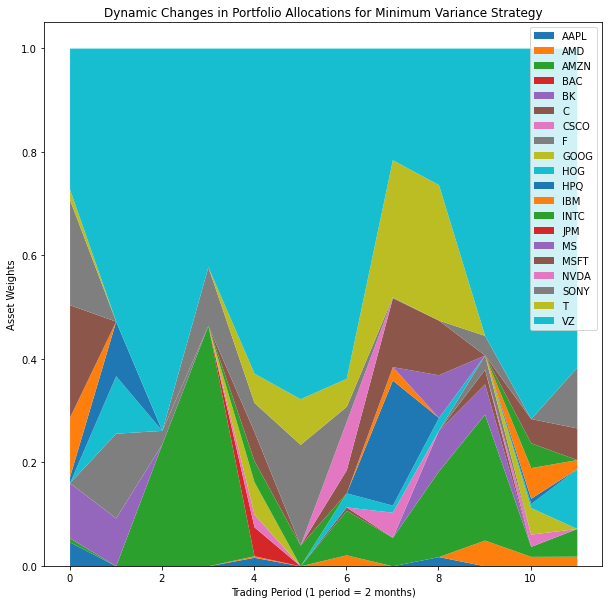

In [9]:
weight_2_df.plot.area(figsize=(10, 10), linewidth=0)

plt.legend()
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Dynamic Changes in Portfolio Allocations for Minimum Variance Strategy')

# Plotting Maximum Sharpe Ratio Dynamic Portfolio Allocation

In [10]:
weight_3 = weight[3].tolist()
weight_3_df = pd.DataFrame(weight_3, columns = df.columns[1:]) # Remove the date

Text(0.5, 1.0, 'Dynamic Changes in Portfolio Allocations for Maximum Sharpe Portfolio')

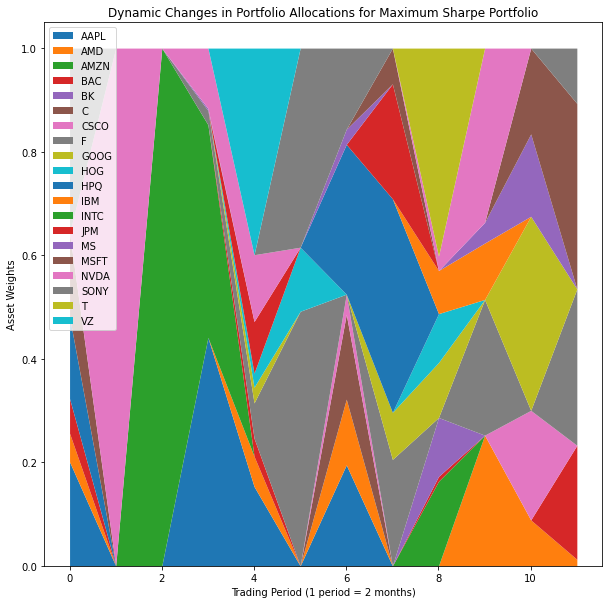

In [11]:
weight_3_df.plot.area(figsize=(10, 10), linewidth=0)

plt.legend()
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Dynamic Changes in Portfolio Allocations for Maximum Sharpe Portfolio')

# Part 3 - Variations of Strategies

In [12]:
# Will select strategy 1/n portfolio at the beginning of period 1 and hold
# Until the end of period 12 (large transaction costs)

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy Equally Weighted and Hold', 'Maximum Sharpe Ratio Portfolio from the start']
N_strat = 1  # comment this in your code
# N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Added

for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
    else:
        cur_year  = 2020 + math.floor(period/7)
    
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
    
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))

            # Compute strategy
            x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[1](curr_positions, curr_cash, mu, Q, cur_prices)
            # Calculate optimal weight as well

        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

            # Compute strategy
            x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
            # Calculate optimal weight as well

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

        # verify strategy is feasible
        if cash[strategy].any() < 0:
            print('Strategy "{0}" is not feasible.'.format(strategy_names[strategy]))

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


        # Compute expected returns and covariances for the next period
        cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
        mu = np.mean(cur_returns, axis = 0)
        Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy Equally Weighted and Hold", value begin = $ 990881.80, value end = $ 892363.31

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy Equally Weighted and Hold", value begin = $ 931075.01, value end = $ 868535.11

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy Equally Weighted and Hold", value begin = $ 837765.40, value end = $ 944421.16

Period 4: start date 07/01/2020, end date 08/31/2020
  Strategy "Buy Equally Weighted and Hold", value begin = $ 940832.47, value end = $ 1096615.92

Period 5: start date 09/01/2020, end date 10/30/2020
  Strategy "Buy Equally Weighted and Hold", value begin = $ 1107923.32, value end = $ 1019219.59

Period 6: start date 11/02/2020, end date 12/31/2020
  Strategy "Buy Equally Weighted and Hold", value begin = $ 1026359.89, value end = $ 1198894.93

Period 7: start date 01/04/2021, end date 02/26/2021
  Strategy "Buy Equally Weighted and Hold", val

In [13]:
# Implement Maximum Sharpe ratio strategy at the beginning of period 1

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Maximum Sharpe Ratio Portfolio from the start']
N_strat = 1  # comment this in your code
# N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Added

for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
    else:
        cur_year  = 2020 + math.floor(period/7)
    
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
    
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))

            # Compute strategy
            x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
            # Calculate optimal weight as well

        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

            # Compute strategy
            x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
            # Calculate optimal weight as well

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

        # verify strategy is feasible
        if cash[strategy].any() < 0:
            print('Strategy "{0}" is not feasible.'.format(strategy_names[strategy]))

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


        # Compute expected returns and covariances for the next period
        cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
        mu = np.mean(cur_returns, axis = 0)
        Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Maximum Sharpe Ratio Portfolio from the start", value begin = $ 990063.05, value end = $ 937633.11

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Maximum Sharpe Ratio Portfolio from the start", value begin = $ 976204.45, value end = $ 1032177.75

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Maximum Sharpe Ratio Portfolio from the start", value begin = $ 988698.20, value end = $ 1192939.18

Period 4: start date 07/01/2020, end date 08/31/2020
  Strategy "Maximum Sharpe Ratio Portfolio from the start", value begin = $ 1237401.70, value end = $ 1630586.54

Period 5: start date 09/01/2020, end date 10/30/2020
  Strategy "Maximum Sharpe Ratio Portfolio from the start", value begin = $ 1665138.92, value end = $ 1576949.92

Period 6: start date 11/02/2020, end date 12/31/2020
  Strategy "Maximum Sharpe Ratio Portfolio from the start", value begin = $ 1575564.70, value end = $ 1816344.79

P